In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report, recall_score, precision_score, make_scorer

%matplotlib inline

url_df = 'https://raw.githubusercontent.com/AngelaBurgaleta/TFM_NHANES/main/DATASETS%20DEFINITIVOS/PROCESSED/df_procesado_genderandage.csv'
url_df45_sinoutliers = 'https://raw.githubusercontent.com/AngelaBurgaleta/TFM_NHANES/main/DATASETS%20DEFINITIVOS/PROCESSED/Sin_outliers/df_v45sinoutliers.csv'
df = pd.read_csv(url_df45_sinoutliers)
df = df.drop(['Unnamed: 0'], axis = 1)


In [3]:
y = df['MET_SYM']
vars_descarte = ['REQ1', 'REQ2', 'REQ3', 'REQ4', 'REQ5', 'REQ_SUM', 'MET_SYM', 'BPXSY1', 'BPXDI1', 'BMXWAIST', 'LBXTR', 'BPQ090D', 'LBDHDD', 'BPQ040A', 'LBXGLU', 'DIQ070', 'BMXHT', 'BMXWT', 'SEQN', 'DPQ050', 'MCQ010', 'DBQ700', 'ALQ130', 'ALQ130_Tramos', 'PAQ665', 'PAQ620', 'PAQ605', 'BPQ050A']
X = df.drop(vars_descarte, axis = 1)

In [ ]:
vars_descarte_ms = ['REQ1', 'REQ2', 'REQ3', 'REQ4', 'REQ5', 'REQ_SUM', 'BPXSY1', 'BPXDI1', 'BMXWAIST', 'LBXTR', 'BPQ090D', 'LBDHDD', 'BPQ040A', 'LBXGLU', 'DIQ070', 'BMXHT', 'BMXWT', 'SEQN', 'DPQ050', 'MCQ010', 'DBQ700', 'ALQ130', 'ALQ130_Tramos', 'PAQ665', 'PAQ620', 'PAQ605', 'BPQ050A']
df_ms = df.drop(vars_descarte_ms, axis = 1)

In [ ]:
#SIN PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [4]:
#CON PCA
#Normalización
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(X)
# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
#Aplicar PCA 
#fijamos componentes
pca = PCA(n_components=26)
X_pca = pca.fit_transform(X)
X_pca.shape
#Separar datos en train, test, entrada y salida despues del PCA
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=30)

#Decision Tree

##Train Classifier

In [ ]:
max_depth=3
random_state=1

# Create decision tree model
model = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)

# Train the model using the training sets
model.fit(X_train_pca, y_train) 

DecisionTreeClassifier(max_depth=3, random_state=1)

In [ ]:
print("Prediction ", model.predict(X_train_pca))
print("Expected ", y_train)

Prediction  [0 0 0 ... 1 1 0]
Expected  22405    0
6084     0
15709    0
2570     0
15713    1
        ..
500      0
12077    1
15277    0
4517     1
5925     0
Name: MET_SYM, Length: 21492, dtype: int64


In [ ]:
# Print the 
print("Predicted probabilities", model.predict_proba(X_train_pca[:10]))

Predicted probabilities [[0.95176227 0.04823773]
 [0.95176227 0.04823773]
 [0.84010695 0.15989305]
 [0.43979779 0.56020221]
 [0.4354603  0.5645397 ]
 [0.43979779 0.56020221]
 [0.95176227 0.04823773]
 [0.43979779 0.56020221]
 [0.95176227 0.04823773]
 [0.95176227 0.04823773]]


In [ ]:
# Evaluate Accuracy in training

from sklearn import metrics
y_train_pred = model.predict(X_train_pca)
print("Accuracy in training", metrics.accuracy_score(y_train, y_train_pred))

Accuracy in training 0.7940163781872325


In [ ]:
# Now we evaluate error in testing
y_test_pred = model.predict(X_test_pca)
print("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))

Accuracy in testing  0.7967615857063093


##Evaluating the algorithm

In [ ]:
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      3215
           1       0.69      0.89      0.78      2158

    accuracy                           0.80      5373
   macro avg       0.80      0.81      0.80      5373
weighted avg       0.82      0.80      0.80      5373

[[2364  851]
 [ 241 1917]]


In [ ]:
print(metrics.confusion_matrix(y_test, y_test_pred))

[[2364  851]
 [ 241 1917]]


##K-fold cross validation

In [ ]:
# create a composite estimator made by a pipeline of preprocessing and the KNN model
model = Pipeline([
        ('scaler', StandardScaler()),
        ('DecisionTree', DecisionTreeClassifier())
])

# create a k-fold cross validation iterator of k=10 folds
cv = KFold(10, shuffle=True, random_state=33)

# by default the score used is the one returned by score method of the estimator (accuracy)
scores = cross_val_score(model, X_pca, y, cv=cv)
print(scores)

[0.78154075 0.7997767  0.79828805 0.79158913 0.7967994  0.78294862
 0.78518243 0.79002234 0.78965004 0.78183172]


In [ ]:

def mean_score(scores):
    return ("Mean score: {0:.3f} (+/- {1:.3f})").format(np.mean(scores), sem(scores))
print(mean_score(scores))

Mean score: 0.805 (+/- 0.003)


#Model Tuning

##Pipelines

In [ ]:
model.named_steps

{'DecisionTree': DecisionTreeClassifier(), 'scaler': StandardScaler()}

In [ ]:
model.steps

[('scaler', StandardScaler()), ('DecisionTree', DecisionTreeClassifier())]

In [ ]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'DecisionTree', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'DecisionTree__ccp_alpha', 'DecisionTree__class_weight', 'DecisionTree__criterion', 'DecisionTree__max_depth', 'DecisionTree__max_features', 'DecisionTree__max_leaf_nodes', 'DecisionTree__min_impurity_decrease', 'DecisionTree__min_samples_leaf', 'DecisionTree__min_samples_split', 'DecisionTree__min_weight_fraction_leaf', 'DecisionTree__random_state', 'DecisionTree__splitter'])

##Tuning the algotihm

In [ ]:
model.get_params()

{'DecisionTree': DecisionTreeClassifier(),
 'DecisionTree__ccp_alpha': 0.0,
 'DecisionTree__class_weight': None,
 'DecisionTree__criterion': 'gini',
 'DecisionTree__max_depth': None,
 'DecisionTree__max_features': None,
 'DecisionTree__max_leaf_nodes': None,
 'DecisionTree__min_impurity_decrease': 0.0,
 'DecisionTree__min_samples_leaf': 1,
 'DecisionTree__min_samples_split': 2,
 'DecisionTree__min_weight_fraction_leaf': 0.0,
 'DecisionTree__random_state': None,
 'DecisionTree__splitter': 'best',
 'memory': None,
 'scaler': StandardScaler(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'steps': [('scaler', StandardScaler()),
  ('DecisionTree', DecisionTreeClassifier())],
 'verbose': False}

##Grid Search for Parameter optimization

Changing manually the parameters to find their optimal values is not practical. Instead, we can consider to find the optimal value of the parameters as an optimization problem.

The sklearn comes with several optimization techniques for this purpose, such as grid search and randomized search. In this notebook we are going to introduce the former one.

The sklearn provides an object that, given data, computes the score during the fit of an estimator on a parameter grid and chooses the parameters to maximize the cross-validation score.

In [ ]:
param_grid = {'max_depth': np.arange(3, 10)} 

gs = GridSearchCV(DecisionTreeClassifier(), param_grid)

gs.fit(X_train_pca, y_train)

# summarize the results of the grid search
print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

Best score:  0.8255628507111126
Best params:  {'max_depth': 8}


In [ ]:
# We print the score for each value of max_depth
for i, max_depth in enumerate(gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (gs.cv_results_['mean_test_score'][i],
                                        gs.cv_results_['std_test_score'][i] * 2,
                                        max_depth))

0.792 (+/-0.004) for {'max_depth': 3}
0.799 (+/-0.011) for {'max_depth': 4}
0.815 (+/-0.009) for {'max_depth': 5}
0.814 (+/-0.005) for {'max_depth': 6}
0.823 (+/-0.004) for {'max_depth': 7}
0.826 (+/-0.003) for {'max_depth': 8}
0.819 (+/-0.008) for {'max_depth': 9}


In [ ]:
#Ajuste de parámetros por validación cruzada
#LLEVA TIEMPO

from sklearn.metrics import classification_report, recall_score, precision_score, make_scorer

#probamos parámetros
tuned_parameters = [{'max_depth': np.arange(3, 10),
#                     'max_weights': [1, 10, 100, 1000]},
                     'criterion': ['gini', 'entropy'], 
                     'splitter': ['best', 'random'],
                    # 'min_samples_leaf': [2, 5, 10],
                     'class_weight':['balanced', None],
                     'max_leaf_nodes': [None, 5, 10, 20]
                    }]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    if score == 'precision':
        scorer = make_scorer(precision_score, average='weighted', zero_division=0)
    elif score == 'recall':
        scorer = make_scorer(recall_score, average='weighted', zero_division=0)
    
    # cv = validación cruzada, por defecto iterador de 5, ajusto a 10
    gs = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=10, scoring=scorer)
    gs.fit(X_train_pca, y_train)

    print("Best parameters set found on development set:")
    print()
    print(gs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']

    for mean_score, std_score, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, std_score * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, gs.predict(X_test_pca)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
#Best parameters set found on development set:


#{'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': None, 'splitter': 'best'}


'''
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3215
           1       0.78      0.81      0.79      2158

    accuracy                           0.83      5373
   macro avg       0.82      0.83      0.83      5373
weighted avg       0.83      0.83      0.83      5373
'''


'\nDetailed classification report:\n\nThe model is trained on the full development set.\nThe scores are computed on the full evaluation set.\n\n              precision    recall  f1-score   support\n\n           0       0.85      0.87      0.86      3215\n           1       0.80      0.78      0.79      2158\n\n    accuracy                           0.83      5373\n   macro avg       0.83      0.83      0.83      5373\nweighted avg       0.83      0.83      0.83      5373\n'

###Prepruning

In [5]:
#Ajuste de parámetros por validación cruzada
#LLEVA TIEMPO

from sklearn.metrics import classification_report, recall_score, precision_score, make_scorer

#probamos parámetros
tuned_parameters = [{ "min_samples_split": [2,5,7,10],
                      "min_samples_leaf": [1,2,5]
}]


   

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    if score == 'precision':
        scorer = make_scorer(precision_score, average='weighted', zero_division=0)
    elif score == 'recall':
        scorer = make_scorer(recall_score, average='weighted', zero_division=0)
    
    # cv = validación cruzada, por defecto iterador de 5, ajusto a 10
    gs = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=10, scoring=scorer)
    gs.fit(X_train_pca, y_train)

    print("Best parameters set found on development set:")
    print()
    print(gs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']

    for mean_score, std_score, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, std_score * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, gs.predict(X_test_pca)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'min_samples_leaf': 5, 'min_samples_split': 7}

Grid scores on development set:

0.788 (+/-0.014) for {'min_samples_leaf': 1, 'min_samples_split': 2}
0.786 (+/-0.011) for {'min_samples_leaf': 1, 'min_samples_split': 5}
0.788 (+/-0.014) for {'min_samples_leaf': 1, 'min_samples_split': 7}
0.789 (+/-0.013) for {'min_samples_leaf': 1, 'min_samples_split': 10}
0.790 (+/-0.012) for {'min_samples_leaf': 2, 'min_samples_split': 2}
0.788 (+/-0.023) for {'min_samples_leaf': 2, 'min_samples_split': 5}
0.790 (+/-0.017) for {'min_samples_leaf': 2, 'min_samples_split': 7}
0.791 (+/-0.018) for {'min_samples_leaf': 2, 'min_samples_split': 10}
0.799 (+/-0.015) for {'min_samples_leaf': 5, 'min_samples_split': 2}
0.799 (+/-0.016) for {'min_samples_leaf': 5, 'min_samples_split': 5}
0.799 (+/-0.017) for {'min_samples_leaf': 5, 'min_samples_split': 7}
0.798 (+/-0.016) for {'min_samples_leaf': 5, 'min_samples_split': 10}

In [ ]:
#Prepruning result
'''
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      3215
           1       0.75      0.75      0.75      2158

    accuracy                           0.80      5373
   macro avg       0.79      0.79      0.79      5373
weighted avg       0.80      0.80      0.80      5373

Best parameters set found on development set:

{'min_samples_leaf': 5, 'min_samples_split': 10}

'''


In [9]:
from sklearn.metrics import roc_auc_score
print("Param for GS", gs.best_params_)
print("CV score for GS", gs.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, gs.predict(X_train_pca)))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, gs.predict(X_test_pca)))

Param for GS {'min_samples_leaf': 5, 'min_samples_split': 10}
CV score for GS 0.7999717986732606
Train AUC ROC Score for GS:  0.9384218499092014
Test AUC ROC Score for GS:  0.7874972073963997


##Modelo tras ajuste de parametros

In [22]:
max_depth= 4
max_leaf_nodes = None
splitter = 'best'
class_weigth = None
criterion = 'gini'
random_state = 1
min_samples_leaf = 5
min_samples_split = 10


# Create decision tree model
model = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, splitter = splitter, criterion = criterion, min_samples_split= min_samples_split, min_samples_leaf = min_samples_leaf )

# Train the model using the training sets
model.fit(X_train_pca, y_train) 

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=10,
                       random_state=1)

In [12]:
print("Prediction ", model.predict(X_train_pca))
print("Expected ", y_train)

Prediction  [0 0 0 ... 1 1 0]
Expected  22405    0
6084     0
15709    0
2570     0
15713    1
        ..
500      0
12077    1
15277    0
4517     1
5925     0
Name: MET_SYM, Length: 21492, dtype: int64


In [23]:
# Evaluate Accuracy in training

from sklearn import metrics
y_train_pred = model.predict(X_train_pca)
print("Accuracy in training", metrics.accuracy_score(y_train, y_train_pred))

Accuracy in training 0.8040666294435138


In [24]:
#importancia de atributos 

feature_importances = model.feature_importances_

In [ ]:
print(feature_importances)

[0.49907256 0.09731549 0.05922866 0.00126755 0.0019815  0.0051323
 0.00076867 0.00199947 0.07976459 0.00380227 0.03287549 0.01009683
 0.00249284 0.00177462 0.14714072 0.00153653 0.00210227 0.0279627
 0.00314414 0.00503515 0.0027685  0.00160631 0.00188766 0.00249033
 0.00218199 0.00089427 0.0036766 ]


In [ ]:
X.columns

Index(['DIQ010', 'INQ020', 'INDFMMPI', 'INDFMMPC', 'BMXBMI', 'BPQ030',
       'BPQ050A', 'LBXIN', 'MCQ080', 'MCQ220', 'MCQ300C', 'HIQ011', 'SMQ020',
       'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'PAQ635', 'PAQ650',
       'HSD010', 'SLQ050', 'DPQ020', 'DPQ030', 'DPQ040', 'RIDAGEYR_Tramos',
       'Etnia_1.0', 'Etnia_2.0', 'Etnia_3.0', 'Etnia_4.0', 'Etnia_6.0',
       'Etnia_7.0', 'WHI'],
      dtype='object')

In [15]:
print(metrics.classification_report(y_test, y_test_pred))
print(' ')
print('----------------')
print(' ')
print(metrics.confusion_matrix(y_test, y_test_pred))

NameError: ignored

##Postpruning

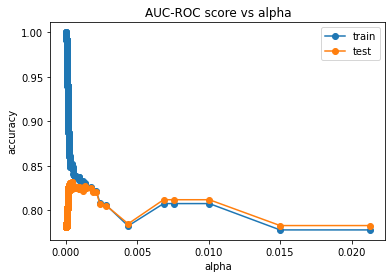

In [16]:
# Allow a decision tree to grow to its full depth
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_pca, y_train)

# compute ccp_alpha values
path = clf.cost_complexity_pruning_path(X_train_pca, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# train DT classifier for each ccp_alpha value
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train_pca, y_train)
    clfs.append(clf)

# Plot train and test score for each of the above trained model    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [roc_auc_score(y_train, clf.predict(X_train_pca)) for clf in clfs]
test_scores = [roc_auc_score(y_test, clf.predict(X_test_pca)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("AUC-ROC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

##roc curve

https://www.projectpro.io/recipes/plot-roc-curve-in-python

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
clf_tree = model

In [ ]:
y_score1 = clf_tree.predict_proba(X_test_pca)[:,1]


In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)


In [ ]:
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1))

roc_auc_score for DecisionTree:  0.9078661337538214


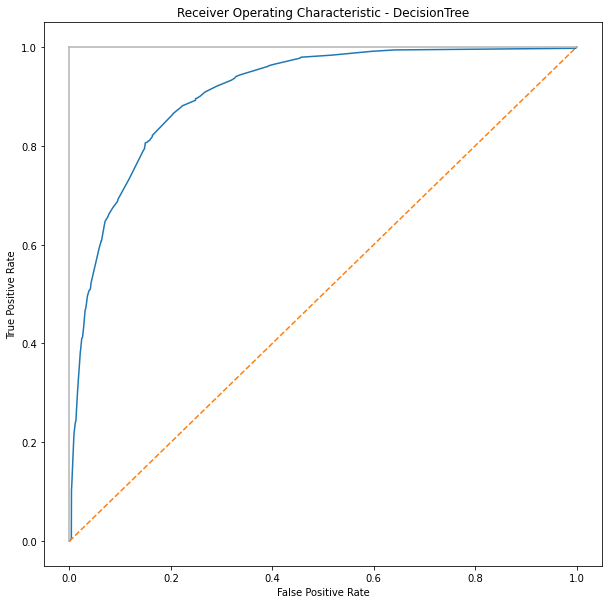

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



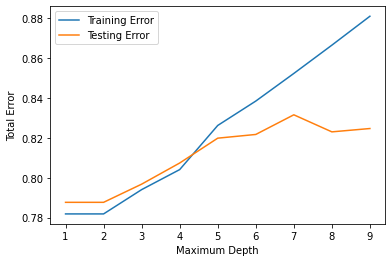

'\nprint("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))\nprint("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))\ny_test_pred = model.predict(X_test_pca)\n\ny_train_pred = model.predict(X_train_pca)\nprint("Accuracy in training", metrics.accuracy_score(y_train, y_train_pred))\n\n\nAs observed from the above plot, with an increase in max_depth training AUC-ROC score continuously increases, but the test AUC score remains constants after a value of max depth. \nThe best-fit decision tree is at a max depth value of 5. Increase the max depth value further can cause an overfitting problem.\n'

In [28]:
#tree train 7 test accuracy against max depth

import numpy as np
import matplotlib.pyplot as plt

max_depth_list = [1,2,3,4,5, 6, 7, 8, 9]

train_errors = [] # Log training errors for each model
test_errors = [] # Log testing errors for each model

for x in max_depth_list:
    model = DecisionTreeClassifier(max_depth=x) 
    model.fit(X_train_pca,y_train)
    y_train_pred = model.predict(X_train_pca)
    y_test_pred = model.predict(X_test_pca)
    train_errors.append(metrics.accuracy_score(y_train, y_train_pred))
    test_errors.append(metrics.accuracy_score(y_test, y_test_pred))

x = np.arange(len(max_depth_list)) + 1 # Create domain for plot
plt.plot(x, train_errors, label='Training Error') # Plot training error over domain
plt.plot(x, test_errors, label='Testing Error') # Plot testing error over domain
plt.xlabel('Maximum Depth') # Label x-axis
plt.ylabel('Total Error') # Label y-axis
plt.legend() # Show plot labels as legend
plt.show() # Show graph


'''
print("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))
print("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))
y_test_pred = model.predict(X_test_pca)

y_train_pred = model.predict(X_train_pca)
print("Accuracy in training", metrics.accuracy_score(y_train, y_train_pred))


As observed from the above plot, with an increase in max_depth training AUC-ROC score continuously increases, but the test AUC score remains constants after a value of max depth. 
The best-fit decision tree is at a max depth value of 5. Increase the max depth value further can cause an overfitting problem.
'''

#SIN PCA

In [ ]:
# create a composite estimator made by a pipeline of preprocessing and the KNN model
model = Pipeline([
        ('scaler', StandardScaler()),
        ('DecisionTree', DecisionTreeClassifier())
])

# create a k-fold cross validation iterator of k=10 folds
cv = KFold(10, shuffle=True, random_state=33)

# by default the score used is the one returned by score method of the estimator (accuracy)
scores = cross_val_score(model, X, y, cv=cv)
print(scores)

In [ ]:

def mean_score(scores):
    return ("Mean score: {0:.3f} (+/- {1:.3f})").format(np.mean(scores), sem(scores))
print(mean_score(scores))

In [ ]:
#Ajuste de parámetros por validación cruzada
#LLEVA TIEMPO

from sklearn.metrics import classification_report, recall_score, precision_score, make_scorer

#probamos parámetros
tuned_parameters = [{'max_depth': np.arange(3, 10),
#                     'max_weights': [1, 10, 100, 1000]},
                     'criterion': ['gini', 'entropy'], 
                     'splitter': ['best', 'random'],
                    # 'min_samples_leaf': [2, 5, 10],
                     'class_weight':['balanced', None],
                     'max_leaf_nodes': [None, 5, 10, 20]
                    }]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    if score == 'precision':
        scorer = make_scorer(precision_score, average='weighted', zero_division=0)
    elif score == 'recall':
        scorer = make_scorer(recall_score, average='weighted', zero_division=0)
    
    # cv = validación cruzada, por defecto iterador de 5, ajusto a 10
    gs = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=10, scoring=scorer)
    gs.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(gs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']

    for mean_score, std_score, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, std_score * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, gs.predict(X_test_pca)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
#Best parameters set found on development set:

#{'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': None, 'splitter': 'best'}

'''
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      3215
           1       0.80      0.78      0.79      2158

    accuracy                           0.83      5373
   macro avg       0.83      0.83      0.83      5373
weighted avg       0.83      0.83      0.83      5373
'''

In [ ]:
#Modelo tras ajuste de parámetros
max_depth= 7
max_leaf_nodes = None
splitter = 'best'
class_weigth = None
criterion = 'gini'
randome_state = 1


# Create decision tree model
model = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, splitter = splitter, criterion = criterion )

# Train the model using the training sets
model.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=7, random_state=1)

In [ ]:
# Evaluate Accuracy in training

from sklearn import metrics
y_train_pred = model.predict(X_train)
print("Accuracy in training", metrics.accuracy_score(y_train, y_train_pred))

Accuracy in training 0.8712544202493951


In [ ]:
#importancia de atributos 

feature_importances = model.feature_importances_
print(feature_importances)

[2.14092159e-02 0.00000000e+00 7.87286312e-04 0.00000000e+00
 3.03210552e-02 4.95809174e-01 9.74722746e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.29716352e-04 5.02831709e-04
 5.05431669e-02 2.28073945e-01 0.00000000e+00 1.10446267e-03
 0.00000000e+00 8.43301038e-04 4.98250353e-04 1.65454073e-03
 0.00000000e+00 6.47364214e-04 5.19834167e-04 4.06734982e-04
 0.00000000e+00 7.92512814e-06 0.00000000e+00 3.45582520e-04
 3.62930544e-04 0.00000000e+00 6.79604070e-02]


In [ ]:
print(metrics.classification_report(y_test, y_test_pred))
print(' ')
print('----------------')
print(' ')
print(metrics.confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      3215
           1       0.69      0.89      0.78      2158

    accuracy                           0.80      5373
   macro avg       0.80      0.81      0.80      5373
weighted avg       0.82      0.80      0.80      5373

 
----------------
 
[[2364  851]
 [ 241 1917]]


In [ ]:
#Visualizacion importancia de parametros 
# Creating a seaborn bar plot
# view the feature scores

feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

##roc curve in PCA

https://www.projectpro.io/recipes/plot-roc-curve-in-python

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
clf_tree = model

In [ ]:
y_score1 = clf_tree.predict_proba(X_test)[:,1]


In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)


In [ ]:
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1))

roc_auc_score for DecisionTree:  0.9268997992208097


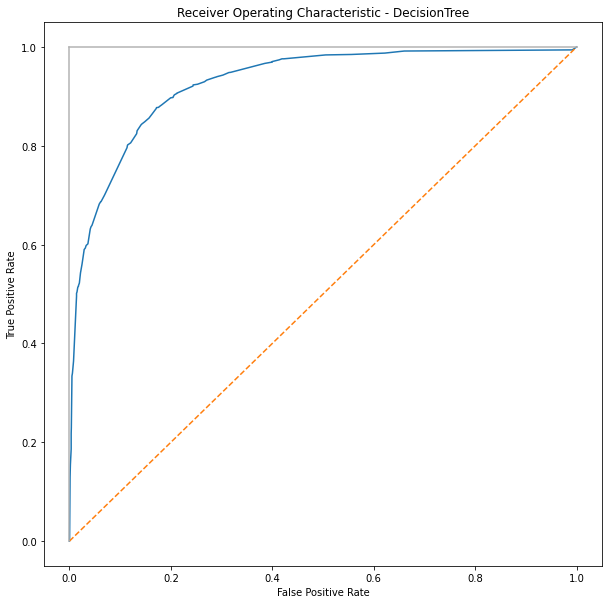

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

